In [1]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pat
import statsmodels.api as sm

## Context
- psychiatric disorders are diagonosed by symptoms (no biological tests) -> heterogeneous groups
- overwhelming majority of analysis focussed on group averages
- ignores individual differences

## Why normative modeling?
 - provides statistical inferences at the level of the individual with respect to an expected pattern
 - permits the detection and mapping of distinct patterns of abnormality in individuals without requiring a consistent neurobiological signature across all individuals


# PyNM
Simple python package that implements three different types of normative models: LOESS, centiles, Gaussian Process. Intended to make it easy to use normative modeling in a wide variety of contexts, and easy to check if the data is consistent with the model assumptions.

## This notebook: 1-getting_started
Introduction to PyNM in simple case, dataset with only age & score.

## Next tutorials:
 - 2-multivariate_confounds
   - data with multivariate confounds e.g. site, age, sex
 - 3-approximate_GP
   - using the Gaussian Process normative model on large datasets
 - 4-prediction
   - using normative modeling as a step in a prediction pipeline

## **Generate data**

First we'll generate some fake data to use in our example. Here we'll look at a score that only varies with age, for which probands have a higher variance and a slight offset.

In [2]:
def model(age):
    noise = np.random.normal(0, 0.3)
    return 0.001*age-0.00001*(age-50)**2*(age-45)**2 + 2.5 + noise


def model_prob(age):
    noise = np.random.normal(0, 0.3)
    return 0.001*age-0.00001*(age-50)**2*(age-45)**2 + 2.5 + 2*noise + 0.2 *np.random.uniform()

def generate_data(group='PROB_CON', sample_size=500, randseed=3):
    np.random.seed(randseed)
    age_min = (np.random.rand(1)*50).astype(int)
    metadata={'prob_ratio': 0.3,
            'age_min': age_min,
            'age_max': (age_min+5+np.random.rand(1)*50).astype(int)}

    participants = []
    for participant in range(sample_size):
        prob = np.random.binomial(1, metadata['prob_ratio'])
        age = np.random.uniform(metadata['age_min'], metadata['age_max'])[0]
        if prob:
            score = model_prob(age)
        else:
            score = model(age)
        participants.append([prob, age, score])

    df = pd.DataFrame(participants, columns=['group', 'age', 'score'])
    if group == 'PROB_CON':
        df.group.replace({1: 'PROB', 0: 'CTR'}, inplace=True)
    return df

In [3]:
df = generate_data(sample_size=888,randseed=101)
print('n subjects = {}'.format(df.shape[0]))

n subjects = 888


In [4]:
df

,group,age,score
0,CTR,30.660215,2.033941
1,CTR,54.489232,2.687490
2,PROB,31.267985,0.695082
3,PROB,56.860946,2.981182
4,CTR,44.917098,2.264944
...,...,...,...
883,PROB,27.817263,-0.379176
884,CTR,51.692079,2.093292
885,PROB,46.310951,2.328100
886,CTR,56.933681,2.446284


## **Visualize data**

Text(0.5, 1.0, 'By PROB/CTR')

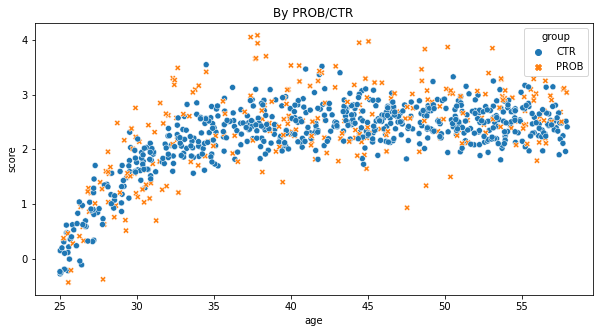

In [5]:
plt.figure(figsize=(10,5))

sns.scatterplot(data=df, x='age', y='score', hue='group', style='group')

plt.title('By PROB/CTR')

## **PyNM - Normative Modeling**

In [6]:
#Initialize pynm w/ data and confounds
m = PyNM(df,'score','group',confounds = ['age'])

Models will be fit on full set of controls.


In [7]:
#Run models
m.loess_normative_model()
m.centiles_normative_model()
m.gp_normative_model()

#Collect output
data = m.data

/home/harveyaa/Documents/masters/PyNM/pynm/pynm.py:516: UserWarning: The residuals are not Gaussian!
  warnings.warn("The residuals are not Gaussian!")
/home/harveyaa/Documents/masters/PyNM/pynm/pynm.py:522: UserWarning: The residuals are heteroskedastic!
  warnings.warn("The residuals are heteroskedastic!")


## **Visualize Normative Models**

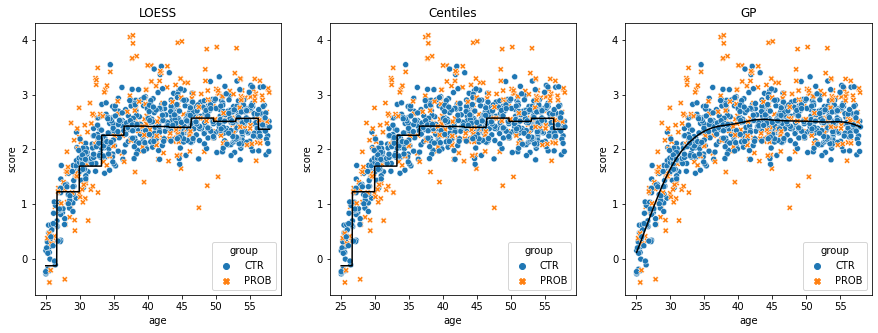

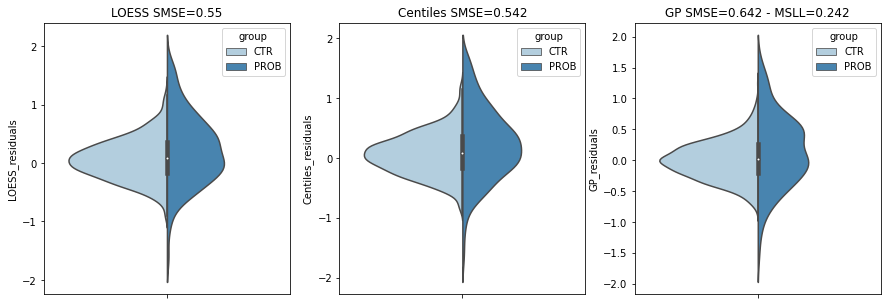

In [8]:
m.plot()
m.plot_res()

## **Case-control**

In [10]:
def case_control(df, group='group',score='score'):
    dmat = pat.dmatrix('C({})'.format(group), df, return_type='dataframe',NA_action='raise')
    results = sm.OLS(m.data[score],dmat).fit()
    return results.pvalues[1]

In [11]:
p_uncorrected = case_control(m.data,score='score')
p_centiles = case_control(m.data,score='Centiles_residuals')
p_loess = case_control(m.data,score='LOESS_residuals')
p_gp = case_control(m.data,score='GP_residuals')

print('Uncorrected: p =', p_uncorrected)
print('Centiles: p =', p_centiles)
print('LOESS: p =', p_loess)
print('GP: p =', p_gp)

Uncorrected: p = 0.034543502446801204
Centiles: p = 3.395095322186183e-07
LOESS: p = 6.554153915297408e-07
GP: p = 3.906021783185763e-07
